# SMD Hands-On "Fitting"

In [15]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import iminuit

def cov_to_corr(cov):
    '''Convert covariance to correlation matrix'''
    D = np.diag(1 / np.sqrt(np.diag(cov)))
    return D @ cov @ D

In [3]:
%matplotlib notebook

## Methode der kleinsten Quadrate

### Analytische Lösung für Linearkombinationen von Funktionen

(Analog zu Aufgabe 27 des letzten Übungszettels)

<IPython.core.display.Javascript object>


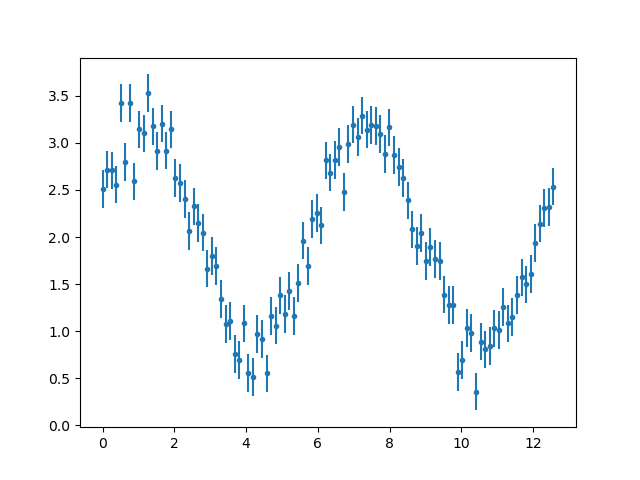

<ErrorbarContainer object of 3 artists>

In [4]:
# Funktionen definieren
def linear_combination(x, funcs, parameters):
    return np.sum([p * f(x) for p, f in zip(parameters, funcs)], axis=0)


funcs = [np.ones_like, np.sin, np.cos]

# Beispieldaten mit MC-Methoden generieren
rng = np.random.default_rng(1337)
N = 100
true_parameters = np.array([2, 1, 0.5])
y_unc = 0.2

x = np.linspace(0, 4 * np.pi, N)
y = linear_combination(x, funcs, true_parameters)

# Messunsicherheit simulieren
y += rng.normal(0, y_unc, N)

plt.figure()
plt.errorbar(x, y, yerr=y_unc, ls='', marker='.')

Aufstellen der Design Matrix

In [5]:
A = np.column_stack([f(x) for f in funcs])
A[:5]

array([[1.        , 0.        , 1.        ],
       [1.        , 0.12659245, 0.99195481],
       [1.        , 0.25114799, 0.9679487 ],
       [1.        , 0.37166246, 0.92836793],
       [1.        , 0.48619674, 0.87384938]])

Aufstellen der Gewichtsmatrix $\boldsymbol{W} = \mathrm{Cov}^{-1}(\mathbf{y})$ der Messwerte

<IPython.core.display.Javascript object>


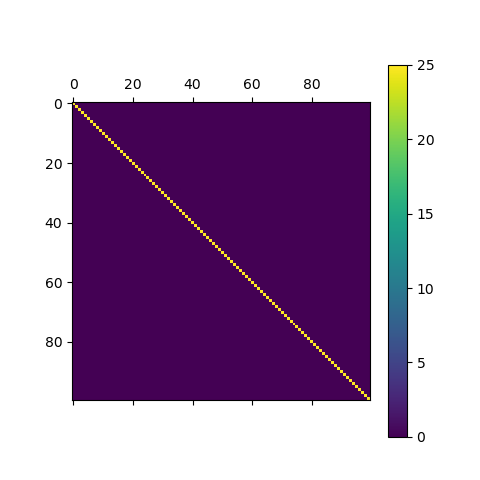

In [6]:
# All measurements have the same, known uncertainty, no correlations
W = np.diag(np.full(N, 1 / y_unc**2)) 
plt.matshow(W)
plt.colorbar()

Berechnung der Lösung und der Kovarianz der Parameter

In [7]:
cov = np.linalg.inv(A.T @ W @ A)

parameters = cov @ A.T @ W @ y
parameters, cov

(array([1.99047482, 1.06383372, 0.54051569]),
 array([[ 4.00079224e-04, -2.43928624e-20, -7.92236086e-06],
        [-2.42506286e-20,  8.08080808e-04, -2.12626522e-20],
        [-7.92236086e-06, -1.35021927e-20,  7.92236086e-04]]))

Chi-Quadrad-Über-Anzahl-Freiheitsgrade

In [8]:
residuals = (y - A @ true_parameters)
ndf = len(y) - len(true_parameters)


sum_residuals = (residuals.T @ W @ residuals)


chisquare_ndf = sum_residuals / ndf
chisquare_ndf

1.0462664047998098

Ergebnis

<IPython.core.display.Javascript object>


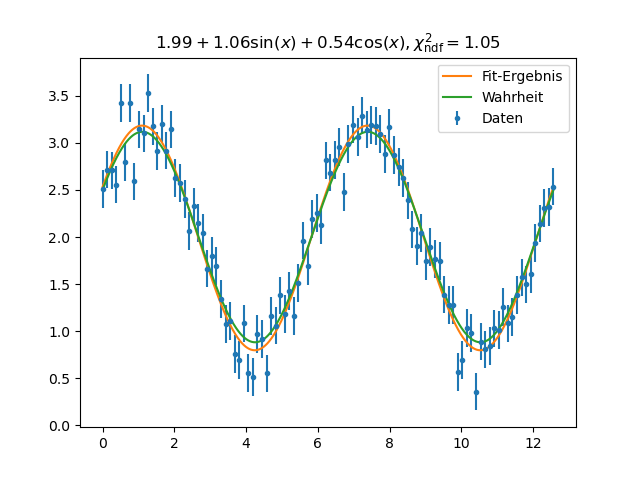

In [9]:
x_fit = np.linspace(0, 4 * np.pi, 1000)
y_fit = linear_combination(x_fit, funcs, parameters)
y_truth = linear_combination(x_fit, funcs, true_parameters)
 

plt.figure()
plt.title(
    rf'${parameters[0]:.2f} + {parameters[1]:.2f} \sin(x) + {parameters[2]:.2f} \cos(x)'
    rf', \chi^2_\mathrm{{ndf}} = {chisquare_ndf:.2f}$'
)
plt.errorbar(x, y, yerr=y_unc, ls='', marker='.', label='Daten')
plt.plot(x_fit, y_fit, label='Fit-Ergebnis')
plt.plot(x_fit, y_truth, label='Wahrheit')
plt.legend()

<IPython.core.display.Javascript object>


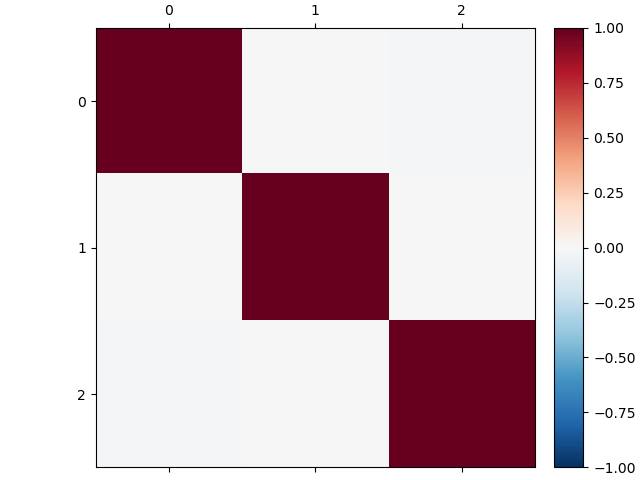

In [10]:
corr = cov_to_corr(cov)

fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)
m = ax.matshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
fig.colorbar(m)

### Numerische Lösung für allgemeine Funktionen


Ist die anzupassende Funktionkeine Linearkombinationen der Parameter einzelner Funktionen, kann die Lösung
nur numerisch gefunden werden.

Aus dem Praktikum bekannt ist die Funktion `scipy.optimize.curve_fit`, die genau dies tut.
Der Nelder-Mead-Algorithmus hat die Eigenschaft, garantiert die korrekte analytische Lösung zu finden, falls sie existiert.

#### Anwendung auf lineares Beispiel

In [17]:
from scipy.optimize import curve_fit


def func(x, p1, p2, p3):
    return p1 + p2 * np.sin(x) + p3 * np.cos(x)


# absolute_sigma prevents scaling of errors to match χ²/ndf=1
parameters_numeric, cov_numeric = curve_fit(func, x, y, sigma=np.full(N, 1/y_unc), absolute_sigma=True)

parameters, parameters_numeric

(array([1.99047482, 1.06383372, 0.54051569]),
 array([1.99047482, 1.06383372, 0.5405157 ]))

<IPython.core.display.Javascript object>


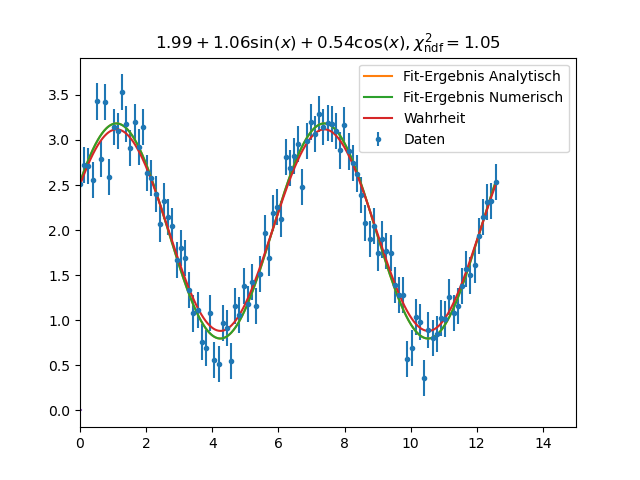

(0.0, 15.0)

In [19]:
x_fit = np.linspace(0, 4 * np.pi, 1000)
y_fit = linear_combination(x_fit, funcs, parameters)
y_num = linear_combination(x_fit, funcs, parameters_numeric)
y_truth = linear_combination(x_fit, funcs, true_parameters)
 

plt.figure()
plt.title(
    rf'${parameters[0]:.2f} + {parameters[1]:.2f} \sin(x) + {parameters[2]:.2f} \cos(x)'
    rf', \chi^2_\mathrm{{ndf}} = {chisquare_ndf:.2f}$'
)
plt.errorbar(x, y, yerr=y_unc, ls='', marker='.', label='Daten')
plt.plot(x_fit, y_fit, label='Fit-Ergebnis Analytisch')
plt.plot(x_fit, y_num, label='Fit-Ergebnis Numerisch')
plt.plot(x_fit, y_truth, label='Wahrheit')
plt.legend(loc='upper right')
plt.xlim(0, 15)

In [13]:
%%timeit
A = np.column_stack([f(x) for f in funcs])
cov = np.linalg.inv(A.T @ W @ A)
parameters = cov @ A.T @ W @ y

47.3 µs ± 993 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%%timeit
parameters_numeric, cov_numeric = curve_fit(func, x, y)

305 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Beispiel mit allgemeiner Funktion 

Aus dem Praktikum, Spaltfunktion

<IPython.core.display.Javascript object>


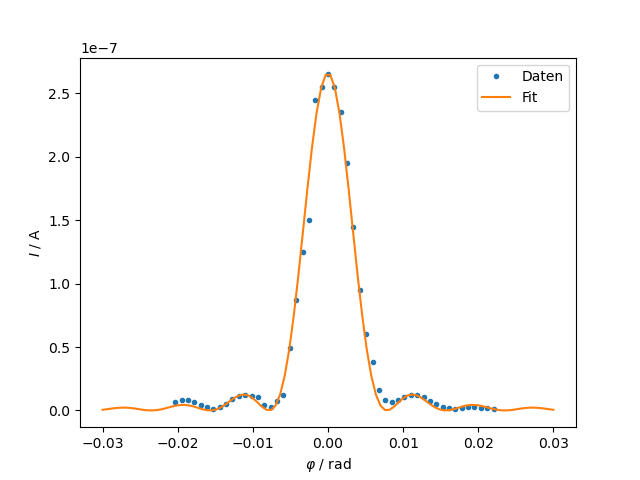

In [33]:
df = pd.read_csv('/home/maxnoe/Uni/pep/toolbox-workshop/exercises-toolbox/8-all/406_Beugung_am_Spalt/spalt.csv')

LAMBDA = 632.8e-9

def theory(phi, A0, b):
    return (A0 * b * np.sinc(b * np.sin(phi) / LAMBDA))**2


p0 = None
p0 = [np.sqrt(df['I'].max()) / 1e-4, 1e-4]

params, cov = curve_fit(theory, df['phi'], df['I'], p0=p0)


plt.figure()
plt.plot(df['phi'], df['I'], '.', label='Daten')


x = np.linspace(-0.03, 0.03, 100)

plt.plot(x, theory(x, *params), label='Fit')
plt.xlabel(r'$\varphi \,\, / \,\, \mathrm{rad}$')
plt.ylabel(r'$I \,\, / \,\, \mathrm{A}$')
plt.legend(loc='best')

## Maximimum-Likelihood-Methode

### Ungebinnter Fit on Wahrscheinlichkeitsdichten


Stark vereinfachtes Beispiel einer CERN-Analyse.

Wir suchen einen Massenpeak eines Teilchens (Normal-verteilt) und haben einen exponential verteilten Untergrund.

<IPython.core.display.Javascript object>


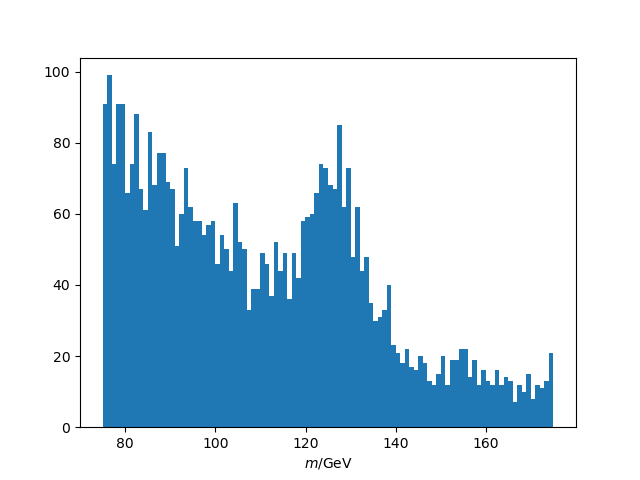

In [32]:
rng = np.random.default_rng(42)

e_min = 75
e_max = 175

higgs_signal = np.random.normal(126, 5, 500)
background = np.random.exponential(50, size=20000)
background = background[(background > e_min) & (background < e_max)]


measured = np.append(higgs_signal, background)

plt.figure()
plt.hist(measured, bins=100)
plt.xlabel('$m / \mathrm{GeV}$')
None

#### Definition der negative Log-Likelihood

Wir bilden eine Überlagerung von zwei Wahrscheinlichkeitsdichten, die einen Anteil von $p$ bzw. $1-p$ haben:

Also:

\begin{align}
P_1 &= N(\mu, \sigma) \\
P_2 &= \frac{1}{\exp(-E_\mathrm{min} / \tau) - \exp(-E_\mathrm{max} / \tau)} \exp(- E / \tau) \\
P(E | p, \mu, \sigma, \tau) &= p \cdot P_1(E, \mu, \sigma) + (1 - p) P_2(E | \tau)) \\
\mathcal{L}(p, \mu, \sigma, \tau) &= \prod_i P(E_i | p, \mu, \sigma, \tau) \\
\log\mathcal{L}(p, \mu, \sigma, \tau) &= \sum_i \log(P(E_i | p, \mu, \sigma, \tau))
\end{align}

In [ ]:
from scipy.stats import norm, expon


def pdf(x, mean, std, tau, p, e_min, e_max):
    N = np.exp(-e_min / tau) - np.exp(-e_max / tau)
    return (
        p * norm.pdf(x, mean, std) 
        + (1 - p) / N * expon.pdf(x, scale=tau)
    )

def neg_log_likelihood(data, mean, std, tau, p, e_min, e_max):
    return -np.sum(np.log(pdf(data, mean, std, tau, p, e_min, e_max)))

In [42]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

eps = np.finfo(np.float64)


loss = UnbinnedNLL(measured, neg_log_likelihood)

minimizer = Minuit(loss, mean=130, std=2, tau=30, p=0.2)

minimizer.limits['std'] = (eps, None)  # > 0
minimizer.limits['tau'] = (eps, None)  # > 0
minimizer.limits['p'] = (0, 1)


result = minimizer.migrad()

<ipython-input-42-ccea078016cd>:9: InitialParamWarning: Parameter e_min does not have neither initial value nor limits.
  minimizer = Minuit(loss, mean=130, std=2, tau=30, p=0.2)
<ipython-input-42-ccea078016cd>:9: InitialParamWarning: Parameter e_max does not have neither initial value nor limits.
  minimizer = Minuit(loss, mean=130, std=2, tau=30, p=0.2)


AttributeError: 'iminuit._libiminuit.Minuit' object has no attribute 'limits'

In [ ]:
from iminuit import __version__
__version__

In [37]:
print('Higgs mass is {:.2f} ± {:.2} GeV'.format(result.x[0], np.sqrt(result.hess_inv.todense()[0, 0])))

Higgs mass is 126.38 ± 2.8 GeV


### Poisson-Fit einer Ereignisverteilung


Beispiel aus Lebensdauer kosmische Myonen (V01)